### Code for published research papers, reproducing (mostly modeling) the results

openAI and deepmind scaling law papers results.

[openAl] (https://arxiv.org/abs/2001.08361)
[deepMind] (https://arxiv.org/abs/2203.15556)

In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [10]:
#parameters calculation from openai scaling laws for neural language model paper
#table 1
def openai_params(seq_len,vocab_size,num_heads,d_model,num_layers):
  embed = (vocab_size+seq_len)*d_model
  attn_dim = d_model//num_heads
  qkv_attn = 3*(d_model*attn_dim)*num_heads
  attn_proj = num_heads*attn_dim*d_model
  ff1 = d_model*4*d_model
  ff2 = 4*d_model*d_model
  #layer_norms = 2*2*d_model # 2 layer _norms per transformer bloc
  layer_norms = 0

  #top of the head layers
  #ln_f = 2*d_model
  ln_f = 0
  #output text
  #output = d_model*vocab_size
  output = 0
  parameters_per_layer = (qkv_attn+attn_proj+ff1+ff2+layer_norms)
  total_parameters = num_layers * parameters_per_layer + ln_f + output
  return total_parameters


def openai_flops(seq_len,vocab_size,num_heads,d_model,num_layers):
  embed = 2*seq_len*vocab_size*d_model
  qkv_proj = 3*2*seq_len*d_model*d_model
  attn_dim = d_model//num_heads
  qk_attn =  2*seq_len*attn_dim*seq_len*num_heads
  qk_mask = 2*seq_len*seq_len
  max_ = seq_len
  exp_ = seq_len
  reduction = seq_len
  softmax = (max_+exp_+reduction)*num_heads*seq_len
  qkv = 2*seq_len*seq_len*attn_dim*num_heads
  attn_proj = 2*seq_len*attn_dim*d_model*num_heads
  self_attn = attn_proj+qkv+softmax+qk_mask+qk_attn
  ##MLP
  ff1 = 2*seq_len*d_model*4*d_model
  ff2 = 2*seq_len*4*d_model*d_model
  de_embed = 2*d_model*vocab_size*seq_len
  tot_flops = num_layers*(de_embed + ff1 + ff2 + self_attn + qkv_proj)
  return tot_flops



Model size (ranging in size from 768 to 1.5 billion non-embedding parameters)
Dataset size (ranging from 22 million to 23 billion tokens)
Shape (including depth, width, attention heads, and feed-forward dimension)
Context length (1024 for most runs, though we also experiment with shorter contexts)
Batch size (219 for most runs, but we also vary it to measure the critical batch size)



In [292]:
#scaling laws chichilla paper  L(N,D) = E + A/N**alpha + B/D**Beta
# first term captures the loss for an ideal generative process on the data distribution should correspond to the entropy of natural text
# second term captures of the loss of transformer model of N parameter underperforming ideal transformer on ideal data set
# third term captures convergence loss due to finite number of steps


#expected loss
def Chinchilla_Loss(N,D):
  alpha = 0.34
  beta  = 0.28
  A     = 406.4
  B     = 410.7
  Entropy = 1.69
  loss =  Entropy + (A/N**alpha) + (B/D**beta)
  return loss

#optimized model for given compute budget
def chinchilla_optmodel(C):
  alpha = 0.34
  beta = 0.28
  A = 406.4
  B = 410.7
  G = ((alpha*A)/(beta*B))**(1/(alpha+beta))
  a = (beta/(alpha+beta))
  Nopt = G*((C/6)**a)
  return Nopt

def chinchilla_opttoken(C):
  alpha = 0.34
  beta = 0.28
  A = 406.4
  B = 410.7
  G = (alpha*A/(beta*B))**(1/(alpha+beta))
  b = (alpha/(alpha+beta))
  Dopt = (1/G)*((C/6)**b)
  return Dopt


def openai_loss(N,D):
  alpha_parameter = 0.076
  alpha_dataset = 0.103
  Nc = 6.4e13
  Dc = 1.8e13
  loss = (((Nc/N)**(alpha_parameter/alpha_dataset))+ (Dc/D))**alpha_dataset
  return loss


def delta_loss(N,D):
  alpha_parameter = 0.076
  alpha_dataset = 0.103
  Nc = 6.4e13
  Dc = 1.8e13
  alpha_param_data = 0.076/0.103
  firstTerm = (N/Nc)**(alpha_param_data)
  secondTerm = ((Dc/D) * firstTerm)+1
  loss = (secondTerm)**alpha_dataset -1
  return loss

def openai_loss_trainingsteps(N,Smin):
  Nc = 6.5e13
  Sc = 2.1e3
  alpha_N = 0.077
  alpha_S = 0.76

  loss = (Nc/N)**alpha_N + (Sc/Smin)**alpha_S
  return loss


def openai_loss_compute(N,C):
  Nc = 6.4e13
  alpha_N = 0.077
  alpha_S = 0.76
  Sc = 2.1e3
  Bcrit = 2.1e8/((2.5)**-4.8)  #loss capped at 2.5
  loss = (Nc/N)**alpha_N + (6*Sc*N*Bcrit/(C*8.64e19))**alpha_S
  return loss

Scaling laws : Deepmind LLM models estimation for optimal models size and tokens using three different approches.

In [11]:
#Approach1
#Table3 data for optimal flops and tokens for each model size.

deepmind_models = {'parameters' : [400e6,1e10,10e10,67e10,175e10,280e10,520e10,1e12,10e12],
                   'tokens': [8e10,20.2e10,205.1e10,1.5e12,3.7e12,5.9e12,11.0e12,21.2e12,216.2e12]}

Flops = [1.92e19,1.21e20,1.23e22,5.76e23,3.85e24,9.90e24,3.43e25,1.27e26,1.3e28]

params_m,params_c = np.polyfit([np.log10(flop) for flop in Flops],[np.log10(params) for params in deepmind_models['parameters']],1)
print(f"y={params_m}x+{params_c}")
tokens_m,tokens_c = np.polyfit([np.log10(flop) for flop in Flops],[np.log10(params) for params in deepmind_models['tokens']],1)
print(f"y={tokens_m}x+{tokens_c}")

y=0.4680832637326815x+0.3785346582505898
y=0.34966131767415587x+4.190900863116923


Text(0.5, 1.0, 'compute-optimal models')

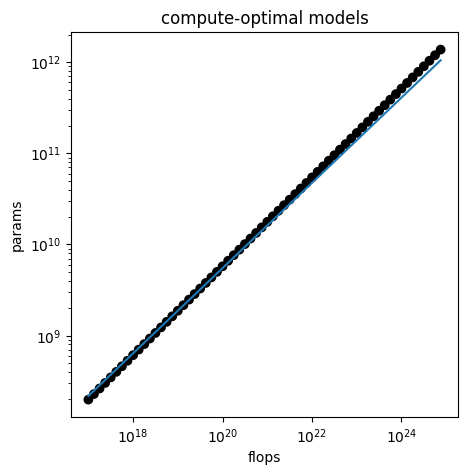

In [12]:
ModelNs = 10 ** np.arange(7,13, step=2**-3)  ## model_size 70M to 1T
flop_count = 10 ** np.arange(17,25,step=2**-3) ## flops e17 to e25
#Table2 power laws co-efficientsfor approach1
params_coeffs = 0.488
colors = ['black']*len(flop_count)
ModelNs = [flop**params_coeffs for flop in flop_count]
plt.figure(figsize=(5,5))
#plot the line
plt.plot([flops for flops in flop_count], [10**(params_m*np.log10(flops)+params_c) for flops in flop_count], label='linear regression')
plt.scatter([flops for flops in flop_count],[params for params in ModelNs],c=colors)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('flops')
plt.ylabel('params')
#plt.colorbar()
plt.title('compute-optimal models')

Text(0.5, 1.0, 'compute-optimal models')

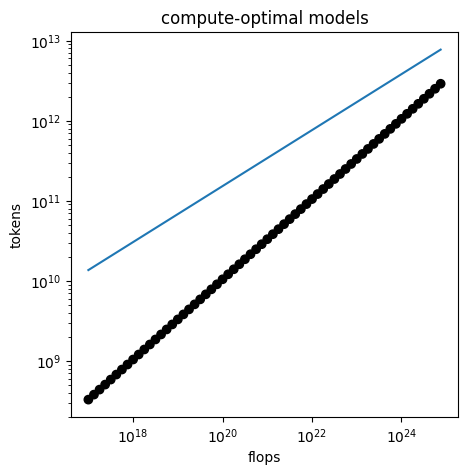

In [13]:
Tokens = 10 ** np.arange(9,17, step=2**-3)  ## Token 70M to 1T
flop_count = 10 ** np.arange(17,25,step=2**-3) ## flops e17 to e25
#Table2 power laws co-efficientsfor approach1
tokens_coeffs = 0.501
colors = ['black']*len(flop_count)
Tokens = [flop**tokens_coeffs for flop in flop_count]
plt.figure(figsize=(5,5))
#plot the line
plt.plot([flops for flops in flop_count], [10**(tokens_m*(np.log10(flops))+tokens_c) for flops in flop_count], label='linear regression')
plt.scatter([flops for flops in flop_count],[params for params in Tokens],c=colors)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('flops')
plt.ylabel('tokens')
#plt.colorbar()
plt.title('compute-optimal models')

#not sure why power coefficients law isnt working for tokens ~ compute

In [14]:
#approach2
# ISOFLOP profiles : vary model-size for a fixed set of training flop counts
# data from tableA3
deepmind_models = {'parameters' : [400e6,1e9,10e9,67e9,175e9,280e9,520e9,1e12,10e12],
                   'tokens': [7.7e9,20e9,219.5e9,1.7e12,4.3e12,7.1e12,13.4e12,26.5e12,292.0e12]}

Flops = [1.84e19,1.20e20,1.32e22,6.88e23,4.54e24,1.18e24,4.19e25,1.59e26,1.75e28]
params_m,params_c = np.polyfit([np.log10(flop) for flop in Flops],[np.log10(params) for params in deepmind_models['parameters']],1)
print(f"y={params_m}x+{params_c}")
tokens_m,tokens_c = np.polyfit([np.log10(flop) for flop in Flops],[np.log10(params) for params in deepmind_models['tokens']],1)
print(f"y={tokens_m}x+{tokens_c}")

y=0.4919810018675344x+-0.8330767315868576
y=0.5121453945100366x+0.067854292038472


Text(0.5, 1.0, 'compute-optimal models')

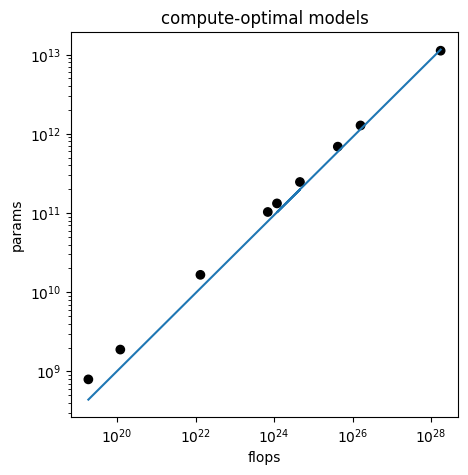

In [15]:
#Table2 power laws co-efficientsfor approach1
params_coeffs = 0.462
colors = ['black']*len(Flops)
ModelNs = [flop**params_coeffs for flop in Flops]
plt.figure(figsize=(5,5))
#plot the line
plt.plot([flops for flops in Flops], [10**(params_m*np.log10(flops)+params_c) for flops in Flops], label='linear regression')
#plt.scatter([flops for flops in Flops],[params for params in deepmind_models['parameters']],c=colors)
plt.scatter([flops for flops in Flops],[params for params in ModelNs],c=colors)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('flops')
plt.ylabel('params')
#plt.colorbar()
plt.title('compute-optimal models')

[7304436624.819598, 19078349391.35943, 211706334483.94363, 1602674328073.5244, 4211265249868.975, 2112533417972.8235, 13139340876196.793, 26008501317287.492, 288692486388150.7]


Text(0.5, 1.0, 'compute-optimal models')

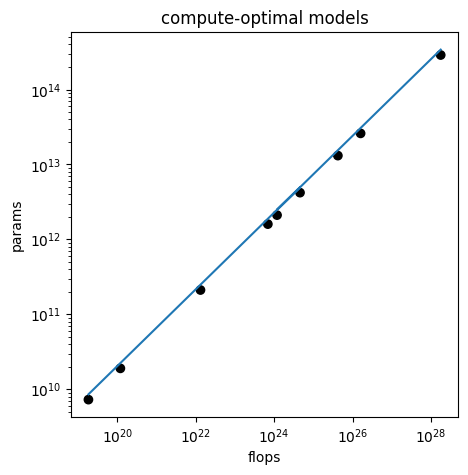

In [16]:
#Table2 power laws co-efficientsfor approach1
token_coeffs = 0.512
colors = ['black']*len(Flops)
ModelNs = [flop**token_coeffs for flop in Flops]
print(ModelNs)
plt.figure(figsize=(5,5))
#plot the line
plt.plot([flops for flops in Flops], [10**(tokens_m*np.log10(flops)+tokens_c) for flops in Flops], label='linear regression')
#plt.scatter([flops for flops in Flops],[params for params in deepmind_models['parameters']],c=colors)
plt.scatter([flops for flops in Flops],[params for params in ModelNs],c=colors)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('flops')
plt.ylabel('params')
#plt.colorbar()
plt.title('compute-optimal models')

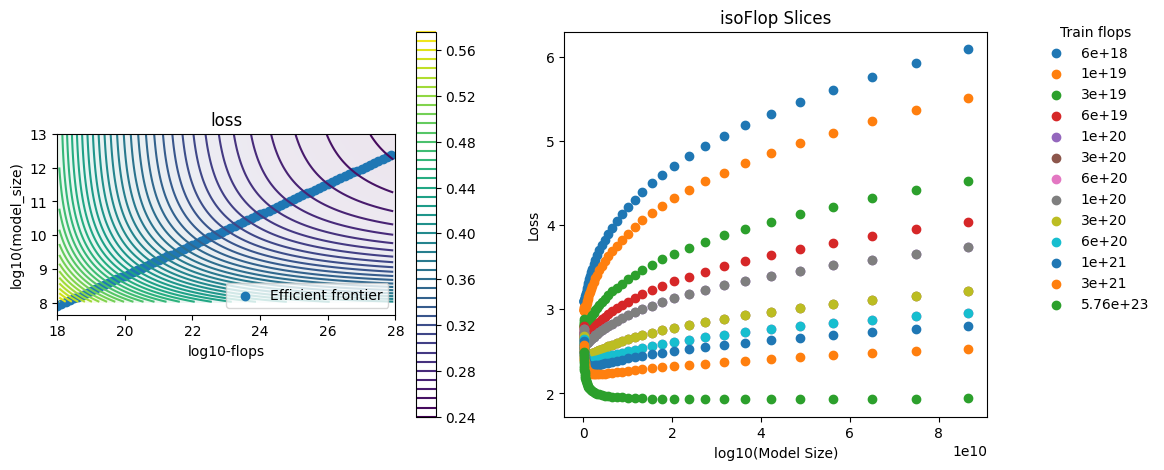

In [17]:
#approach3
nParams = 10 ** np.arange(8,13, step=2**-4)  ## model_size 100M to 10T
numTokens = 10 ** np.arange(9,14, step=2**-4)  ## dataset size range 1B to 100T
plt.figure(figsize=(12,5))
plt.subplot(121)
Flops = [1.84e19,1.20e20,1.32e22,6.88e23,4.54e24,1.18e24,4.19e25,1.59e26,1.75e28]
efficient_frontier = {'flops': Flops}
efficient_frontier['model_size'] = [chinchilla_optmodel((flops)) for flops in efficient_frontier['flops']]

eff_m,eff_c = np.polyfit([np.log10(flop) for flop in Flops],[np.log10(params) for params in efficient_frontier['model_size']],1)

flops=np.log10(np.array([[6*param*token for token in numTokens] for param in nParams]))
flops_min = np.min(flops)
flops_max = np.max(flops)
frontier_flops = np.arange(18,28,step=2**-3)
loss_list = np.log10(np.array([[Chinchilla_Loss(param,token) for token in numTokens] for param in nParams]))
plt.scatter(frontier_flops,[np.log10(chinchilla_optmodel(10**(flops))) for flops in frontier_flops])
#plt.plot(frontier_flops, [10**(eff_m*np.log10(flops)+eff_c) for flops in frontier_flops], label='linear regression')
plt.imshow(loss_list, extent=[18,28,8,13], origin='lower', alpha=0.1)
plt.contour(loss_list, levels=50, extent=[18,28,8,13], origin='lower')
frontier_flops = 10**np.arange(18,28,step=2**-4)
colors=['black']*len(frontier_flops)
plt.xlabel('log10-flops')
plt.ylabel('log10(model_size)')
plt.title('loss')
plt.colorbar()
plt.legend(["Efficient frontier"], ncol = 1 , loc = "lower right")

#plot loss for each model size with varying compute flop budget
plt.subplot(122)
train_flops = [6e18,1e19,3e19,6e19,1e20,3e20,6e20,1e20,3e20,6e20,1e21,3e21,5.76e23]
for flops in train_flops:
   # range over model sizes
    model_size = 10 ** np.arange(8, 11, step=2**-4)
    # the dataset sizes that would maintain the given compute budget
    dataSize = flops / (6 * model_size)
    # losses at each point
    losses = Chinchilla_Loss(model_size, dataSize)
    label_name = flops
    plt.scatter(model_size,losses,label=str(flops))

plt.xlabel('log10(Model Size)')
plt.ylabel('Loss')
plt.title('isoFlop Slices')
plt.legend(bbox_to_anchor=(1.1, 1.05), frameon=False,title='Train flops')


In [18]:
#chinchilla optimal models database

flops_range = 10** np.arange(17,26,step=2**-9)
chinchilla_models = []

for flop in flops_range:
    # range of model sizes
    model_size = np.arange(7, 13, step=2**-9)
    token_size = flop / (6*model_size)

    #power law losses
    loss = Chinchilla_Loss(model_size,token_size)

    best_fit = np.argmin(loss)
    chinchilla_models.append((flop,model_size[best_fit],token_size[best_fit]))



2.139967055936762


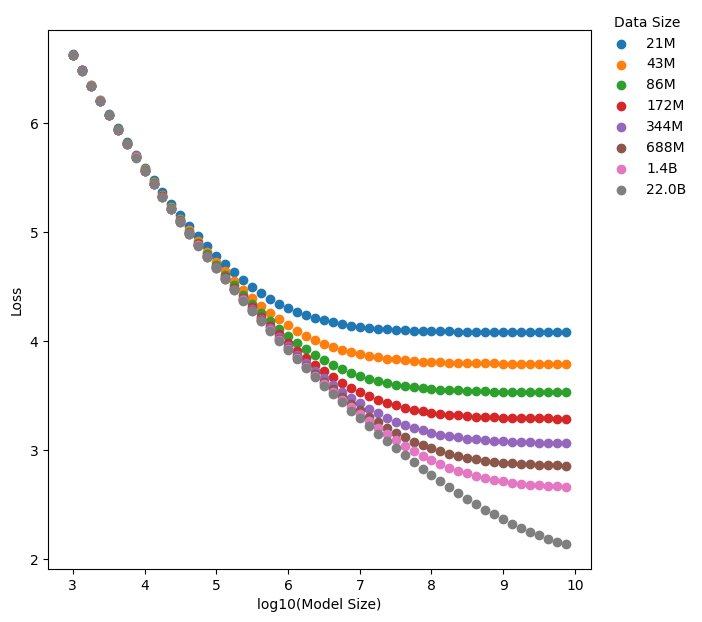

In [80]:
#openAi
#Section 4.1  proposed L(N,D) equation

numTokens = 10 ** np.arange(7,12, step=2**-6)  ## dataset size range 1B to 100T
numParams = 10**np.arange(3,10, step=2**-3)  ## model-size 1k to 10B
plt.figure(figsize=(7,7))
model_size = np.arange(3,10, step=2**-3)
tokens = [21e6,43e6,86e6,172e6,344e6,688e6,1.4e9,22e9]
tokens_str = ["21M","43M","86M","172M","344M","688M","1.4B","22.0B"]
bestfit = 10000
for idx,token in enumerate(tokens):
    # losses at each point
    losses = openai_loss(numParams, token)
    plt.scatter(model_size,losses,label=tokens_str[idx])
    bestfit = np.min(losses)
plt.xlabel('log10(Model Size)')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.2, 1.05), frameon=False,title='Data Size')




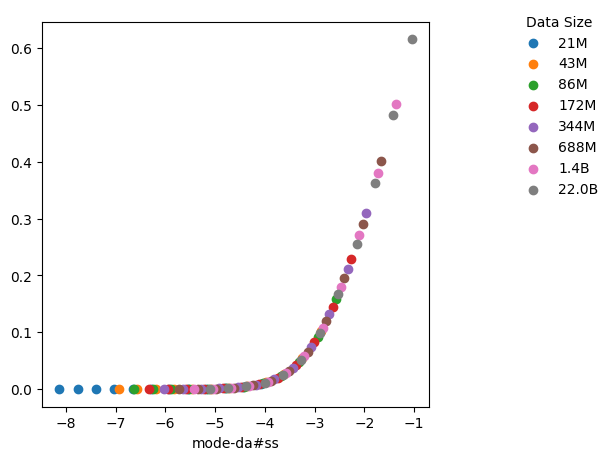

In [57]:
#fix data size increase model-size
tokens = [21e6,43e6,86e6,172e6,344e6,688e6,1.4e9,22e9]
ratio = ["1e-7","1e-6","1e-5","1e-4","1e-3","1e-2","1e-1","1"]
numParams = 10**np.arange(3,9, step=2**-1)  ## model-size 1k to 10B
tokens.reverse()
plt.figure(figsize=(5,5))
deltalosses=[]
modeldata_ratio=[]


for idx, token in enumerate(tokens):
    delta_losses = [delta_loss(params,token) for params in numParams]
    model_data_ratio = [((params**(0.076/0.103))/token) for params in numParams]
    deltalosses.append(delta_losses)
    modeldata_ratio.append(model_data_ratio)
    plt.scatter([np.log10(ratio) for ratio in model_data_ratio],delta_losses,label=tokens_str[idx])


#_ratio = sum(modeldata_ratio,[])
#_losses = sum(deltalosses,[])
#overfit_m,overfit_c = np.polyfit([ratio for ratio in _ratio],[loss for loss in _losses],1)
#plt.plot([np.log10(ratio) for ratio in _ratio], [(overfit_m*(ratio)+overfit_c) for ratio in _ratio], label='linear regression')
plt.xlabel('mode-da#ss')
plt.legend(bbox_to_anchor=(1.2, 1.05), frameon=False,title='Data Size')


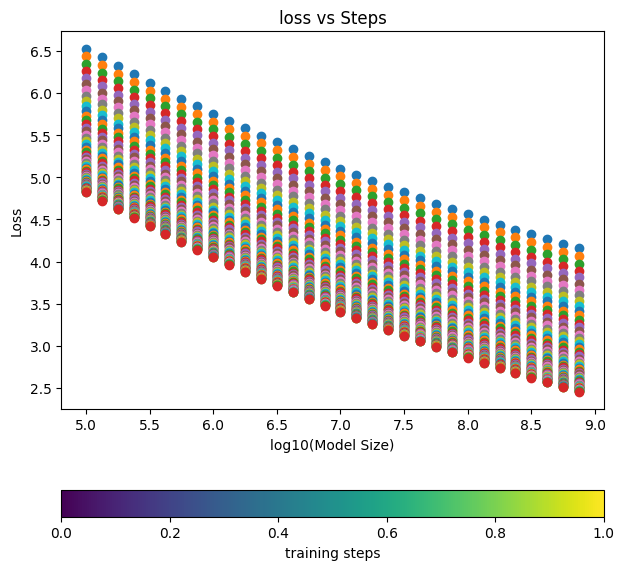

In [279]:
# Section 5.1  Model-size and Training Time (universality of trianing time)
# for finding critical batch-size for efficient training-time and compute resources for attaining specific loss
# batch-size fas function of loss for given network.

# LEt S be the number of training step(S) and B is batch-size , then total number of tokens processed by the network(N) E= B*S
# Emin is minimum number of tokens that must be processed by the network(N), Smin is minimum number of training steps 
# Emin = B*Smin
# E = BS
# Smin = (S/(1+Bcrit(L)/B))   Smin(S) - minimum number of training steps needed when B>>Bcrit  S= number of trianing steps when B=2e19
# PF-days = 8.64e19
# compute-minimum needed to arrive loss L for network(N) if we were to train B<<Bcrit 
# Cmin(C) = C/(1+B/Bcrit(L))
# Bcrit = 2e8/L(1/0.21)

#fixing compute time and measure performance of model through loss
#L (N,Smin) = (Nc/N)**alpha_n + (Sc/Smin)**alpha_S
# Nc = 6.5e13 Sc = 2.1e3 alpha_n = 0.077 alpha_s =0.76

Compute_days = 10**np.arange(8,19, step=2**-3)

#batch-size scan
Batch_size=1e19
training_steps = 10 ** np.arange(3,5,step=2**-5) 

#critical batch-size is independent of model-size. so pick webtext2 and sweep through models to find best batch-size from loss-function
numParams = 10**np.arange(5,9, step=2**-3)  ## model-size 1k to 10B'

loss = np.arange(1,10,step=2**-5)
Bcrit = []
for idx in loss:
  Bcrit.append(2e8/(idx**(1/0.21)))

batch_crit = np.max(Bcrit)  # close to emprical 2.1e8

Smin = []
#Use Bcrit to find relation between number of training steps when B=2e19 and the training steps B>>Bcrit
for steps in training_steps:
  Smin.append(steps/(1+(batch_crit/Batch_size))) 
plt.figure(figsize=(7,7))


model_size = np.arange(5,9, step=2**-3)
for steps in Smin:
  losses = [openai_loss_trainingsteps(params,steps) for params in numParams]
  plt.scatter(model_size,losses)

plt.xlabel('log10(Model Size)')
plt.ylabel('Loss')
plt.title('loss vs Steps')
plt.colorbar(label="training steps", orientation="horizontal")
#plt.legend(bbox_to_anchor=(1.2, 1.05), frameon=False,title='Steps')


48


Text(0.5, 1.0, 'loss vs Steps')

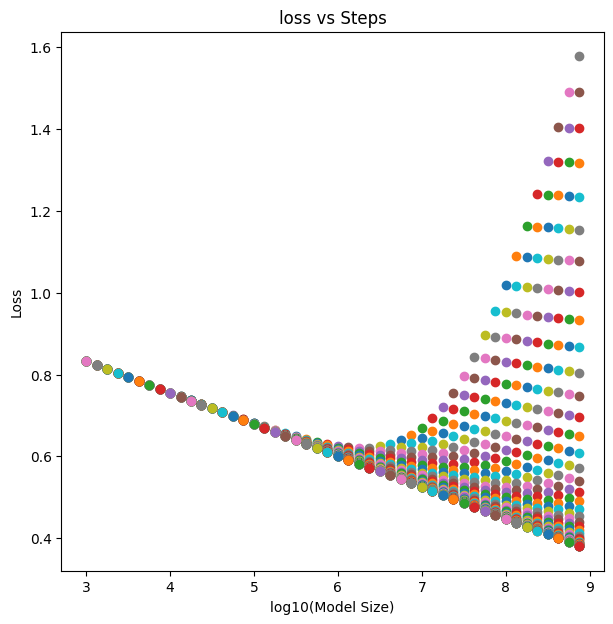

In [278]:
plt.figure(figsize=(7,7))
numParams = 10**np.arange(3,9, step=2**-3)  ## model-size 1k to 10B'
model_size = np.arange(3,9, step=2**-4)
#Compute_days = np.arange(0.00001,10, step=2**-10)

Compute_days = 10**np.arange(14,20,step=2**-3)/1e19
print(len(Compute_days))
Batch_size = 1e4
for idx,compute in enumerate(Compute_days):
  perf = []
  for params in numParams:
    cmin = (compute*8.64e19/(1+(Batch_size/batch_crit)))
    #print(cmin)
    smin= cmin/(6*params*Batch_size)
    #perf.append(openai_loss_trainingsteps(params,smin))
    loss = openai_loss_trainingsteps(params,smin)
    #print(loss)
    plt.scatter(np.log10(params),np.log10(loss),c)
#print(C_min)
plt.xlabel('log10(Model Size)')
plt.ylabel('Loss')
plt.title('loss vs compute-flops')

In [ ]:
#appendix -A
#finding optimal openAI models for given compute budget

#L(N,S) = (Nc/N)**alpha_N + (Sc/S)**alpha_S
# S = C/6*N*B(L)
# B(L) = Batch_size/loss**(1/alpha_B)
#L(N,C) = (Nc/N)**alpha_N + (Sc*6*Bcrit*N/C*Loss**1/Alpha_B)

openAiModels=[]

compute_flops = 10** np.arange(3,12,step=2**-8)  #in PF-days
model_size = numParams = 10**np.arange(3,12, step=2**-6)
for flops in compute_flops:
    losses = [openai_loss_compute(params,flops) for params in model_size]
    bestfit  = np.argmin(losses)
    datasize = flops/(6*model_size)
    openAiModels.append((flops,model_size[bestfit],datasize[bestfit]))

#replace S = 6*N*Bcri

print(len(openAiModels))



In [296]:
modelParams=175e9
model_size = np.array([paramS for flops,paramS,dataS in openAiModels])
data_size = np.array([dataS for flops,params,dataS in openAiModels])
flops = np.array([flops for flops,params,dataS in openAiModels])
idx = np.argmin(np.abs(model_size-modelParams))
print("Nearest  openAi model found:")
print(f"model size: {model_size[idx]/1e9:.2f}M")
print(f"dataset size: {data_size[idx]/1e9:.2f}B")
print(f"flops (PF-days): {flops[idx]:e}")
print(f"loss: {openai_loss_compute(model_size[idx], flops[idx]):.2f}")

closest openAimodel found:
model size: 177.83M
dataset size: 0.00B
flops (PF-days): 4.869675e+06
loss: 1.74
